# FigureOneLabs: Proper acquisition of cell class identity in organoids allows definition of fate specification programs of the human cerebral cortex (Uzquiano, 2022)
## Preparing the data

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

In [2]:
# Create an account for Broad Single Cell Portal
# Download data from https://singlecell.broadinstitute.org/single_cell/study/SCP1756/cortical-organoids-atlas#study-download

Read in the metadata file and prepare the dataframe.

In [3]:
meta = pd.read_csv('./data/meta_all.txt', sep='\t') # Specify that the file is tab-separated
meta

/var/folders/tj/nksd2rpd1zv9gsz28dlj1r0c0000gn/T/ipykernel_80217/510930202.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('./data/meta_all.txt', sep='\t') # Specify that the file is tab-separated


,NAME,biosample_id,donor_id,nGene,nUMI,sex,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,biosample_type
0,TYPE,group,group,numeric,numeric,group,group,group,group,group,group,group,group,group,group
1,AAACGAAAGACACAAT-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,3850,5327,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
2,AAACGAAAGACCTATC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,2070,2556,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
3,AAACGAAAGATTGACA-2_1m-ATAC,ATAC-Org2,Mito 210 c1 b5,2708,3334,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
4,AAACGAAAGCGTCTGC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,3970,5339,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777088,PCW18_TTTGTTGGTCACCGAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2298,5225,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue
777089,PCW18_TTTGTTGGTGACAGCA-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,6308,24794,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue
777090,PCW18_TTTGTTGGTTAGAAAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,1142,2062,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue
777091,PCW18_TTTGTTGTCACCCTTG-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2881,7919,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue


In [4]:
# Drop the first row of the dataframe
meta.drop(index=0, axis=0, inplace=True) # index=0 specifies the row to drop, axis=0 indicates that it is a row, inplace=True modifies the dataframe rather than returning a new dataframe
# Drop the specified columns
meta.drop(columns=['species','species__ontology_label',
                   'disease','disease__ontology_label',
                   'organ','organ__ontology_label',
                   'library_preparation_protocol'], inplace=True) # List of columns to drop
# Rename the specified columns using a dictionary where the keys are current column names and values are the new names
meta.rename(columns={'NAME':'CellID', 'biosample_id':'SampleID'}, inplace=True)
meta

,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type
1,AAACGAAAGACACAAT-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,3850,5327,male,scATAC-seq,DerivedType_Organoid
2,AAACGAAAGACCTATC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,2070,2556,male,scATAC-seq,DerivedType_Organoid
3,AAACGAAAGATTGACA-2_1m-ATAC,ATAC-Org2,Mito 210 c1 b5,2708,3334,male,scATAC-seq,DerivedType_Organoid
4,AAACGAAAGCGTCTGC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,3970,5339,male,scATAC-seq,DerivedType_Organoid
5,AAACGAAAGGATATCA-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,2590,3279,male,scATAC-seq,DerivedType_Organoid
...,...,...,...,...,...,...,...,...
777088,PCW18_TTTGTTGGTCACCGAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2298,5225,unknown,10X sequencing,PrimaryBioSample_Tissue
777089,PCW18_TTTGTTGGTGACAGCA-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,6308,24794,unknown,10X sequencing,PrimaryBioSample_Tissue
777090,PCW18_TTTGTTGGTTAGAAAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,1142,2062,unknown,10X sequencing,PrimaryBioSample_Tissue
777091,PCW18_TTTGTTGTCACCCTTG-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2881,7919,unknown,10X sequencing,PrimaryBioSample_Tissue


Identify and count the combinations of protocols and sample type that have been used in the study.

In [5]:
# Select the two columns and count unique combinations
meta[['library_preparation_protocol__ontology_label','biosample_type']].value_counts()

library_preparation_protocol__ontology_label  biosample_type         
10X sequencing                                DerivedType_Organoid       601747
                                              PrimaryBioSample_Tissue     60806
single cell sequencing                        DerivedType_Organoid        53232
scATAC-seq                                    DerivedType_Organoid        38017
Slide-seq                                     DerivedType_Organoid        23290
Name: count, dtype: int64

Identify what samples can be found in the dataframe.

In [6]:
# Find the unique values of the SampleID column
meta['SampleID'].unique()

array(['ATAC-Org3', 'ATAC-Org1', 'ATAC-Org2', 'ATAC-Org5', 'ATAC-Org6',
       'ATAC-Org4', 'ATAC-Org8', 'ATAC-Org9', 'ATAC-Org7',
       'SlideSeq-1m-Org1', 'SlideSeq-1m-Org2', 'SlideSeq-1m-Org4',
       'SlideSeq-1m-Org3', 'SlideSeq-2m-Org1', 'SlideSeq-2m-Org2',
       'SlideSeq-2m-Org3', 'SlideSeq-3m-Org1', 'SlideSeq-3m-Org2',
       'SlideSeq-3m-Org3', 'Org1', 'Org2', 'Org3', 'Org4', 'Org5', 'Org6',
       'Org7', 'Org8', 'Org9', 'Org10', 'Org11', 'Org12', 'Org13',
       'Org14', 'Org15', 'Org16', 'Org17', 'Org18', 'Org19', 'Org20',
       'Org21', 'Org22', 'Org23', 'Org24', 'Org25', 'Org26', 'Org27',
       'Org28', 'Org29', 'Org30', 'Org31', 'Org32', 'Org33', 'Org40',
       'Org41', 'Org42', 'Org43', 'Org44', 'Org45', 'Org34', 'Org35',
       'Org36', 'Org37', 'Org38', 'Org39', 'Org46', 'Org47', 'Org48',
       'Org49', 'Org50', 'Org51', 'Org55', 'Org56', 'Org57', 'Org52',
       'Org53', 'Org54', 'Org58', 'Org59', 'Org60', 'Org61', 'Org62',
       'Org63', 'Org64', 'Org65', 'O

Read in the file that contains the 23 days RNA-Seq data to generate the counts matrix.

*Notes:*
* **Matrix Market file:** a standardised file format for storing matrices, especially sparse ones, used for efficient storage and exchange.
* **Sparse matrix:** a matrix predominantly composed of zero elements, stored in specialised formats to save memory and improve computational efficiency.
* **Compressed Sparse Row (CSR) format:** a popular method for storing sparse matrices efficiently. This format is particularly advantageous for arithmetic operations, row slicing, and matrix-vector products.

In [7]:
# Read the matrix from the file
counts = scipy.io.mmread('./data/expression_23days.txt') # scipy.io.mmread is function from the scipy library that reads a Matrix Market file and returns a sparse matrix
# Transpose the matrix (swap its rows and columns)
counts = counts.transpose()
# Convert the transposed matrix to a CSR format
counts = scipy.sparse.csr_matrix(counts)
# Returns the shape of the matrix as a tuple, representing the number of rows and columns
counts.shape

(29736, 33694)

The `counts` matrix contains 29,736 rows and 33,694 rows.

Read in the file that contains the barcodes for each cell analysed at 23 days.

In [8]:
barcodes = pd.read_csv('./data/NormExpression_23days_barcodes.txt', sep='\t', header=None) # Specify that the file does not have a header row
# Rename the column
barcodes.rename(columns={0:'CellID'}, inplace=True)
barcodes

,CellID
0,1_AAACGAACACGTGAGA-1_1_23d
1,1_AAACGAAGTCGAAACG-1_1_23d
2,1_AAACGAAGTGGCAGAT-1_1_23d
3,1_AAACGAAGTGGTTCTA-1_1_23d
4,1_AAACGAAGTTGGCCGT-1_1_23d
...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d
29732,3_TTTGGTTTCGGTTAGT-1_2_23d
29733,3_TTTGTTGAGACCATAA-1_2_23d
29734,3_TTTGTTGAGAGAAGGT-1_2_23d


Read in the file that contains the genes analysed at 23 days.

In [9]:
genes = pd.read_csv('./data/NormExpression_23days_genes.txt', sep='\t', header=None)
# Rename the column
genes.rename(columns={0:'Genes'}, inplace=True)
genes

,Genes
0,RP11-34P13.3
1,FAM138A
2,OR4F5
3,RP11-34P13.7
4,RP11-34P13.8
...,...
33689,AC233755.2
33690,AC233755.1
33691,AC240274.1
33692,AC213203.1


Count the number of cells in the `barcode` dataframe that also exist in the `meta` dataframe (i.e. count the cells in the `barcode` dataframe that we have metadata for).

In [10]:
# Check each element in the CellID column of barcodes to see if it is present in the CellID column of meta
# This returns a boolean Series of the same length as barcodes['CellID'], where each element is True if the corresponding CellID is found in meta[`CellID`]
barcodes['CellID'].isin(meta['CellID'])

0        True
1        True
2        True
3        True
4        True
         ... 
29731    True
29732    True
29733    True
29734    True
29735    True
Name: CellID, Length: 29736, dtype: bool

In [11]:
# Sum the True values in the boolean Series (where True is treated as 1 and False is treated as 0)
sum(barcodes['CellID'].isin(meta['CellID']))

29736

Create a filtered `meta` dataframe that contains only the cells analysed at 23 days.

In [12]:
# Check if each CellID in the meta dataframe exists in the barcodes dataframe, returning a boolean Series
a = meta['CellID'].isin(barcodes['CellID'])
# Use the boolean Series, a, to filter the rows of the meta dataframe - only rows where a is True are selected
b = meta[a]
# Merge the barcodes dataframe with the filtered meta dataframe based on the CellID column
# This is a left join, meaning all rows in the barcodes dataframe are kept, and matching rows from b are included
# If there is no match in b, the resulting dataframe will have NaN for these columns
meta_d23 = pd.merge(barcodes, b, on='CellID', how='left')
meta_d23

#a = meta['SampleID'].isin(['Org1', 'Org2', 'Org3', 'Org4', 'Org5', 'Org6'])
#meta_d23 = meta[a]
#meta_d23

,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type
0,1_AAACGAACACGTGAGA-1_1_23d,Org1,Mito 210 c1 b1,536,3724,male,10X sequencing,DerivedType_Organoid
1,1_AAACGAAGTCGAAACG-1_1_23d,Org1,Mito 210 c1 b1,2310,9184,male,10X sequencing,DerivedType_Organoid
2,1_AAACGAAGTGGCAGAT-1_1_23d,Org1,Mito 210 c1 b1,2070,6359,male,10X sequencing,DerivedType_Organoid
3,1_AAACGAAGTGGTTCTA-1_1_23d,Org1,Mito 210 c1 b1,1292,3468,male,10X sequencing,DerivedType_Organoid
4,1_AAACGAAGTTGGCCGT-1_1_23d,Org1,Mito 210 c1 b1,832,1809,male,10X sequencing,DerivedType_Organoid
...,...,...,...,...,...,...,...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d,Org6,PGP1 c1 b2,995,1825,male,10X sequencing,DerivedType_Organoid
29732,3_TTTGGTTTCGGTTAGT-1_2_23d,Org6,PGP1 c1 b2,3449,13964,male,10X sequencing,DerivedType_Organoid
29733,3_TTTGTTGAGACCATAA-1_2_23d,Org6,PGP1 c1 b2,1382,3670,male,10X sequencing,DerivedType_Organoid
29734,3_TTTGTTGAGAGAAGGT-1_2_23d,Org6,PGP1 c1 b2,1331,3713,male,10X sequencing,DerivedType_Organoid


Combine the expression data (`counts`), cell metadata (`meta_d23`), and gene metadata (`genes`) into a single `AnnData` object. This is commonly used for handling annotated data matrices, particularly in single-cell genomics.

In [13]:
# Create an AnnData object
adata = anndata.AnnData(X=counts, # The primary data matrix, counts, is the expression data
                        obs=meta_d23, # The observation annotations, meta_d23, contains metadata about the observations (cells)
                        var=genes) # The variable annotations, gene, contains metadata about the variables (genes)
adata

/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 29736 × 33694
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type'
    var: 'Genes'

In [14]:
#adata.var_names_make_unique

Using the `scanpy` library, which is commonly used for scRNA-seq data analyse, filter genes and cells in `adata`:
* Genes that are expressed in fewer than 10 cells should be filtered out.
* Cells that express fewer than 200 genes should be filtered out.

*Notes:*
* Filtering genes helps to reduce noise by eliminating genes with very low expression across the dataset. 
* Filtering cells helps to remove low-quality or potential empty droplets in the scRNA-seq data.

In [15]:
# sc.pp.filter_genes is a function from the scanpy library that filters genes based on their expression across cells
# min_cells is the minimum number of cells a gene must be expressed in to be retained
sc.pp.filter_genes(adata, min_cells=10)
# sc.pp.filter_cells is a function from the scanpy library that filters cells based on the number of genes they express
# min_genes is the minimum number of genes a cell must express to be retained
sc.pp.filter_cells(adata, min_genes=200)

In [16]:
adata

AnnData object with n_obs × n_vars = 29736 × 20589
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes'
    var: 'Genes', 'n_cells'

Ensure that the primary data matrix (`X`) in the `AnnData` object is stored in a CSR format, which is important for large scRNA-seq datasets.

Create a new layer called `counts` in the `AnnData` object, storing a CSR format copy of the primary data matrix. Layers in `AnnData` are used to store different versions or transformations of the primary data matrix.

In [17]:
# Create a copy of the expression data matrix (X) to avoid modifying the original data directly
# scipy.sparse.csr_matrix converts the copied matrix to CSR format and assigns it back to adata.X
adata.X = scipy.sparse.csr_matrix(adata.X.copy())
# Create another copy of the expression data matrix to ensure that the data is the new layer is also a separate copy
# Conver the copied matrix to CSR format and assign to a new layer named counts
adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
#adata.layers['log2_counts'] = sc.pp.log1p(adata.layers['counts'].copy(), base=2)

Train a Single-Cell Variational Inference (SCVI) model on the scRNA-seq data contained in the `AnnData` object, considering batch effects specified by `SampleID`. 

*Notes:*
* The SCVI model is a probabilistic model used to analyse scRNA-seq data.
* SCVI leverages variational autoencoders (VAEs), a type of deep learning model, to capture the underlying structure and variability in high-dimension scRNA-seq data.
* **VAEs:**
    * VAEs are a type of generative model that learn a low-dimension latent representation of the data.
    * They consist of an encoder network that maps the high-dimensional input data to a low-dimensional latent space, and a decoder network that reconstructs the input data from the latent representation.
    * The latent space captures the underlying structure and variability in the data.
* **Negative Binomial Likelihood:**
    * scRNA-seq data are count data, often modelled using the negative binomial distribution to account for overdispersion (variance greater than the mean).
* **Batch effect correction:**
    * scRNA-seq experiments are often conducted in multiple batches, leading to batch-specific technical variations.
    * SCVI includes batch correction mechanisms by integrating batch information into the model.
* The learnt low-dimensional representation of the gene expression data can then be used for downstream analysis such as dimensionality reduction (low-dimensional representation of the data for visualisation), clustering (identifying distinct cell populations based on their gene expression profiles) and differential expression analysis (identifying genes that are differentially expressed between different cell types or conditions).
* **Parameters:**
    * **n_layers:** the number of hidden layers in the encoder and decoder neural networks. Increasing the number of layers can allow the model to capture more complex patterns in the data but also increases the computational cost and risk of overfitting.
    * **n_latent:** the dimensionality of the latent space. The latent space is a lower-dimensional representation of the data learned by the model. A higher number of dimensions can capture more variation but also required more parameters to be learned.
    * **n_hidden:** the number of hidden units in each hidden layer of the encoder and decoder neural networks. More hidden units increase the capacity of the model to learn complex patterns, but also increase the computational cost and risk of overfitting.
    * **gene_likelihood:** the likelihood model used for gene expression. The choice of likelihood model determines how the model interprets the distribution of gene expression counts.

In [ ]:
%%time
random.seed(17)
# Prepare the AnnData object for use with the SCVI model
# Specify that the data for the model should be taken from the counts layer
# Specify the column in the obs dataframe that contains batch information
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='SampleID')
# Initialise the SCVI model using scvi.model.SCVI
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
# Train the SCVI model
scvi_model.train()
# Save the SCVI model
scvi_model.save('./scvi_model_checkpoint', overwrite=True)

In [18]:
# Load the previously saved SCVI model
scvi_model = scvi.model.SCVI.load('./scvi_model_checkpoint', adata=adata) # The adata parameter is necessary when loading the model to ensure it has the correct AnnData object associated with it

INFO     File ./scvi_model_checkpoint/model.pt already downloaded                                                  


Use the trained SCVI model to obtain a latent representation of the data and normalise the gene expression counts.

*Notes 1:*
* A latent representation refers to a lower-dimensional space where the data is represented by a set of features that capture the most significant aspects of the original high-dimensional data.
* In the context of scRNA-seq data, the latent representation is a learned, compressed version of the gene expression data that retains essential biological information while reducing noise and complexity.
* **Dimensionality reduction:**
    * The orgininal gene expression matrix can have thousands of genes (features) for each cell (observation), resulting in a very high-dimensional space.
    * Dimensionality reduction techniques, such as those used in SCVI, transform this high-dimensional data into a lower-dimensional space with fewer features while preserving the important structure and variability of the data.
* **VAE:**
    * SCVI uses a type of deep learning model called a VAE to learn the latent representation.
* **Capturing biological variability:**
    * The latent space learned by SCVI aims to capture the underlying biological variability in the data, such as different cell types, states or conditions.
    * The compressed representation helps to highlight meaningful patterns and relationships that might be obscured by noise or technical variability in the original high-dimensional data.

*Notes 2:*
* Library size normalisation is the process of adjusting raw gene expression counts to account for differences in sequencing depth (total number of reads/unique molecular identifiers (UMIs) per cell).
* Cells in scRNA-seq experiments can have varying sequencing depths due to technical differences or biological variability.
* A common practice is the normalise the expression data to a fixed library size, often 10,000 reads/UMIs per cell (this is somewhat arbitrary).
* Normalisation typically involves the following steps:
    * **Calculate size factors:** determine a size factor for each cell, which is the total number of reads/UMIs for that cell.
    * **Scale counts:** adjust each gene's count in each cell by dividing by the cell;s size factor and then multiplying by the chosen library size.

In [19]:
random.seed(17)
# Extract the low-dimensional latent representation of the data learned by the SCVI model and store in the obsm attribute of the AnnData object, under the key 'X_scvi'
# The obsm (observation multi-dimensional) attribute is a dictionary that can hold arrays such as dimensionality reduction results
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
# Normalise the expression counts by a specified library size (e.g. 10,000 reads per cells) to adjust for differences in sequencing depth across cells
# Store the normalised expression data in the layers attribute of the AnnData object, under the key 'counts_scvi'
# The layers attribute is a dictionary that can hold multiple versions of the expression data, such as raw counts, normalised counts, and imputed counts
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

The latent representation `X_scvi` contains the latent representation of the cells, which can be used for visualisation (e.g. UMAP, t-SNE) or clustering.

The normalised expression `counts_scvi` contains the normalised gene expression counts, which can be used for differential expression analysis.

Perform clustering and visualisation of the scRNA-seq data using the SCVI model's latent representation.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
<timed exec>:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


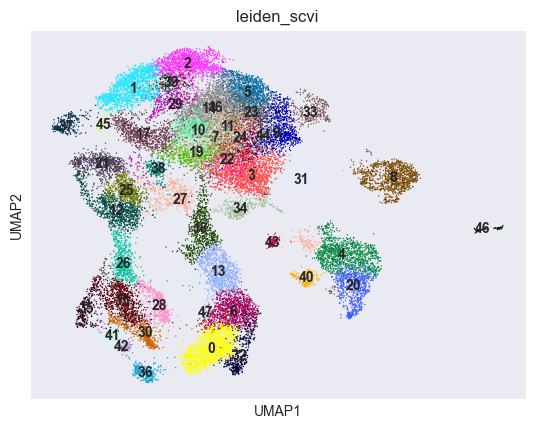

CPU times: user 1min 1s, sys: 2.34 s, total: 1min 3s
Wall time: 1min 4s


In [20]:
%%time
# Compute the neighborhood graph of observations (cells)
# use_rep='X_scvi' uses the SCVI latent representation for computing neighbors
# key_added='neighbors_scvi' stores the computed neighborhood graph in adata.uns with the key 'neighbors_scvi'
# n_neighbors=20 specifies the number of neighbors to consider for each cell
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
# Perform Leidan clustering to identify clusters of cells
# neighbours_key='neighbours_scvi' uses the previously computed neighborhood graph for clustering
# key_added='leiden_scvi' stores the cluster labels in adata.obs with the key 'leiden_scvi'
# resolution=3 specifies the resolution parameter for the Leiden algorithm - higher values lead to more clusters
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
# Compute a UMAP embedding for visualisation using the neighborhood graph (neighbors_scvi)
# UMAP coodinates are stored in adata.obsm with the key `X_umap`
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
# Plot the UMAP embedding colouring the cells based on the Leiden clustering labels (leidan_scvi)
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

This is a UMAP plot, which visualises the cells in two-dimensional space:
* Each point represents a cell, positioned according to the UMAP embedding.
* The points are coloured based on their Leidan cluster labels, where each cluster is assigned a different colour.

In [21]:
adata.obs

,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type,n_genes,_scvi_batch,_scvi_labels,leiden_scvi
0,1_AAACGAACACGTGAGA-1_1_23d,Org1,Mito 210 c1 b1,536,3724,male,10X sequencing,DerivedType_Organoid,536,0,0,38
1,1_AAACGAAGTCGAAACG-1_1_23d,Org1,Mito 210 c1 b1,2310,9184,male,10X sequencing,DerivedType_Organoid,2310,0,0,14
2,1_AAACGAAGTGGCAGAT-1_1_23d,Org1,Mito 210 c1 b1,2070,6359,male,10X sequencing,DerivedType_Organoid,2068,0,0,35
3,1_AAACGAAGTGGTTCTA-1_1_23d,Org1,Mito 210 c1 b1,1292,3468,male,10X sequencing,DerivedType_Organoid,1291,0,0,26
4,1_AAACGAAGTTGGCCGT-1_1_23d,Org1,Mito 210 c1 b1,832,1809,male,10X sequencing,DerivedType_Organoid,831,0,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d,Org6,PGP1 c1 b2,995,1825,male,10X sequencing,DerivedType_Organoid,994,5,0,13
29732,3_TTTGGTTTCGGTTAGT-1_2_23d,Org6,PGP1 c1 b2,3449,13964,male,10X sequencing,DerivedType_Organoid,3449,5,0,1
29733,3_TTTGTTGAGACCATAA-1_2_23d,Org6,PGP1 c1 b2,1382,3670,male,10X sequencing,DerivedType_Organoid,1382,5,0,9
29734,3_TTTGTTGAGAGAAGGT-1_2_23d,Org6,PGP1 c1 b2,1331,3713,male,10X sequencing,DerivedType_Organoid,1329,5,0,11


Four columns were added to `adata.obs`:
* `n_genes`: added when the `sc.pp.filter_cells` function was called. This function computes the number of genes expressed in each cell and stores it in this column.
* `_scvi_batch`: an internal column created by `scvi-tools` during the setup of the `AnnData` object for the SCVI model. It encodes batch information based on the `SampleID` column and is used by the SCVI model to account for batch effects during training.
* `_svci_labels`: an internal column created by `scvi-tools` during the set of the `AnnData` object for the SCVI model. It typically encodes the labels used by the SCVI model during training.
* `leiden_scvi`: contains the cluster labels assigned to each cell by the Leiden clustering algorithm.

nsure each column in the `obs` attribute of the `AnnData` object has the correct data types.

In [22]:
adata.obs['CellID'] = adata.obs['CellID'].astype(str)
adata.obs['SampleID'] = adata.obs['SampleID'].astype(str)
adata.obs['donor_id'] = adata.obs['donor_id'].astype(str)
adata.obs['nGene'] = adata.obs['nGene'].astype(int)
adata.obs['nUMI'] = adata.obs['nUMI'].astype(int)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs['library_preparation_protocol__ontology_label'] = adata.obs['library_preparation_protocol__ontology_label'].astype(str)
adata.obs['biosample_type'] = adata.obs['biosample_type'].astype(str)
adata.obs['leiden_scvi'] = adata.obs['leiden_scvi'].astype(str)

In [ ]:
%%time
adata.write('./outs/231228_uzquiano_d23_rna_scvi.h5ad')
scvi_model.save('./outs/231228_uzquiano_d23_rna_scvi_model/')